# Computer Assignment 5b) -- Group 2
* Ali Bemani
* Martin Hellkvist

This document is structured like this:
* Problem setup
    * Describes the problem setup in ADMM
    * Preprocessing of data
* Summary of Results
* Implementation

## Problem setup

In this computer assignment, the main aim is to find a hyper-plane W that separates MNIST data linerly in the space where the data resides, with the use of ADMM algorithm. This can be posed as the following optimization problem

Given a dataset $\{(x_i,y_i)\}_{i=1}^I (x_i \in \mathbb{R}^n,y_i \in -1,+1)$ in L2-regulirized.
L2-loss (squared hinge loss) SVM we have
$$ \min_{w} C\sum_{i=1}^I max(0,1-y_iw^Tx_i) $$

Same as CA4, we only use the binary SVM classifier and we ignore multiclass SVM classifier for somplicity.
The task of linear classification is now distributed among various workers, for this each worker will have a different random dataset. Now to make the problem amenable to decomposition, we consider that we have $\{N_1, N_2,\cdots,N_M\}$ as apartition of data with indices $\{1,2,\cdots,I\}$

Now, we can write the SVM in the distributed setting like this
$$ \min_{w} C\sum_{m=1}^M \sum_{i\in [N_m]} max(0,1-y_iw_m^Tx_i)$$

Where M is the number of workers in the network. Now each worker works with it's own dataset and tries to find an optimal $w$ for it's iteration, so we can consider that, there is no single $w$, there is a set of whight vectors which each worker tries to solve it's optimization problem. We represent each of these weight vectors by $w_m$ for $m=1,2,\cdots,M$ workers.
Finally we want to find the global vector $w$ to be a unique vector, so we can limith our optimization problem with subject to this condition:

$$ w_m = z_{mj}, j\in \mathcal{N}_m ,$$

together with that all the auxiliary edge variables $z_{mj}$ to be equal over all pairs of connected workers:

$$ z_{mj} = z_{jm}, m,j \in \mathcal{E}, $$
we can see it as between each pair of connected workers, 
there are two auxiliary variables, which should 

So the distributed SVM problem takes the following form


$$ \begin{align}
\min_{w_1,\dots,w_M} & \sum_{m=1}^M f_m(w_m) \\
\text{s.t.}~~  w_m &= z_{mj},~ j\in\mathcal{N}_m \\
 z_{ij} &= z_{ji},~ i,\,j ~\in \mathcal{E}
\end{align}$$


Now we can write the augmented lagrangian
    $$L_{\rho}(w,z,\mu) 
    = \sum_{m=1}^M f_m(w_m) 
    + \sum_{m=1}^M \sum_{j\in\mathcal{N}_m}\mu_{mj}^T(w_m - z_{mj}) 
    + \frac{\rho}{2}\sum_{m=1}^M\sum_{j\in\mathcal{N}_m} ||w_m - z_{mj}||^2_2 $$

Now we use ADMM to optimize this augmented lagrangian problem. So we have the following update results
$$\begin{align}
    w_m^{k+1} &= \text{arg}\min_{w_m} f_m(w_m)
                + \sum_{j\in\mathcal{N}_m}(\mu_{mj}^k)^T(w_m - z_{mj}^k)
                + \frac{\rho}{2}\sum_{j\in\mathcal{N}_m} ||w_m - z_{mj}^k||^2_2\\
    z_{mj}^{k+1} &= \frac{1}{2}\left(w_m^{k+1} + w_j^{k+1} + \frac{1}{\rho}(\mu_{mj}^k + \mu_{jm}^k)\right),~j\in\mathcal{N}_m \\
    \mu_{mj}^{k+1} &= \mu_{mj}^k + \rho(w_m^{k+1} - z_{mj}^{k+1}), ~ j\in\mathcal{N}_m
\end{align}$$

with solving these two optimization problem for updating $w$ and $z$ we can reach to update itterations. before that we consider that $ f_m(w) = \max(0, 1 - y_i w_m^T x_i) $ and we use the following subgradient for gradient descent:
$$ \partial f_m(w) = -y_i x_i, ~~\text{if}~~ 1 - y_i w_m^T x_i > 0,~~ \text{otherwise} ~~ \partial f_m(w) = 0 $$

So we can solve the optimization problem for finding $"w"$ like this
$$ \partial f_m(w_m^k) + \sum_{j\in\mathcal{N}_m} \mu_{mj}^k + \frac{\rho}{2}\sum_{j\in\mathcal{N}_j}(2w_m^k - 2z_{mj}^k) = 0 $$
$$w_j^{k+1} = \frac{1}{\rho|\mathcal{N}_j|} \left(  \rho\sum_{j\in\mathcal{N}_j} (z_{mj}^k - \mu_{mj}^k) - \partial f_m(w_m^k)  \right) $$

For updating $"z"$ we have
$$  z_{mj}^{k+1} = \frac{1}{2}\left( w_m^{k+1} + w_j^{k+1} + \frac{1}{\rho}(\mu_{mj}^k + \mu_{jm}^k) \right)  $$

and for $\mu_{mj}$:
$$ \mu_{mj}^{k+1} = \mu_{mj}^k + \rho(w_m^{k+1} - z_{mj}^{k+1})  $$

Finally, we have the following update results
$$
\begin{align}
w_j^{k+1} &= \frac{1}{\rho|\mathcal{N}_j|} \left(  \rho\sum_{j\in\mathcal{N}_j} (z_{mj}^k - \mu_{mj}^k) - \partial f_m(w_m^k)  \right) \\
z_{mj}^{k+1} &= \frac{1}{2}\left( w_m^{k+1} + w_j^{k+1} + \frac{1}{\rho}(\mu_{mj}^k + \mu_{jm}^k) \right) \\
\mu_{mj}^{k+1} &= \mu_{mj}^k + \rho(w_m^{k+1} - z_{mj}^{k+1}) 
\end{align}
$$

In this way, in node $m$ in each iteration $w_j$ and $\mu_{jm}$ needs to be collected from all neighbours in $\mathcal{N}_m$ 

## Preprocessing of data
Same as CA5 a).

## Results 5 b)
We find it difficult to characterize the convergence in this type of decentralized setup. 
Our first idea was to in each iteration compute the cost as the hinge-loss produced by one workers estimate on the whole training data set.
This let us first think that both algorithms converged within 10-20 iterations.
However, a closer look, and considering different workers for the cost revealed that the workers were converging at different rates.
This happens because of several factors, including the randomized initialization in both $w$, $\mu$ and $z$.

The second approach was to compute the hinge loss of each worker on the test data set.
This cost is difficult to  draw conclusions from as well, because the ADMM is very "jumpy" in cost.

The third and most successful approach was to compute the accuracy on the test data in each iteration,
averaged over all workers.
This allowed us to see that ADMM converges around iteration 180,
while the decentralized subgradient method (DSGM) converges around iteration 230.

To count the number of "signal exchanges" per iteration we counted like this:
* DSGM
    * In each iteration, all the nodes averages over the $w$ of their neighbors.
    We assume node 5 and 6 to broadcast their $w_5$ and $w_6$ each iteration (2 exchanges),
    while the other nodes send to node 5 and 6, respectively (1 exchange per node).
    This totals to $2+1*8=10$ signal exchanges per iteration $t$: $T=10t$.
* ADMM
    * In each iteration, worker 5 broadcasts $w_5$ and also it broadcasts $\mu_{51},\mu_{52},\mu_{53},\mu_{54},\mu_{56}$  (6 exchanges). Similiarly, worker 6 has 6 exchanges.
    The other nodes $m\neq 5,6$ broadcasts $w_m$ and also $\mu_{m5}$ or $\mu_{m6}$ depending on which star worker it is connected to.
    This totals to $6+6+2\times 8=28$ signal exchanges per iteration $t$: $T=28t$.
    
    
Convergence:
* DSGM, $\alpha=5$
    * 1028 out of 1031 correct predictions
    * 220 iterations
    * 2200 signal exchanges
* ADMM $\rho=0.1$
    * 1026 out of 1031 correct predictions
    * 180 iterations
    * 5040 signal exchanges
    
Regarding this convergence, there is some discussion to be had though.
The running DSGM for 100 iterations give all correct predictions on the test data when we average over all the workers' estimates $𝑤$ , but it goes down again after that, to converge around 1031.
This behavior can maybe be explained by some node lagging behind, due to an unlucky initialization or such coincidences. Therefore we do not say it has converged until the accuracy is stable over the number of iterations

### Tuning of parameters
We started off by setting $\alpha$ for DSGM way too small at around $0.03$ and less.
This gave convergence around several thousands of iterations to a way lower accuracy.

It later turned out that we could have $\alpha>1$ and get very fast convergence to often times 100% accuracy.

The parameter $\rho$ for ADMM gives more fluctuation on results and slow convergence if it is $\rho<0.05$ but it was not very difficult to tune it, after realizing this values, one can triangularize to a larger, more suiting value, and the algorithm runs quite quickly for this dataset, so it is not so much of a problem.

Both methods have similar runtime in this implementation but ADMM needs a quick more time. We have $3.6 sec$ for DSGM and $5 sec$ for ADMM.

## Implementation

In [1]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
import sys
import matplotlib.pyplot as plt
import mnist
from PIL import Image

from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace


# the "resource" library is not available on windows. 
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource
    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")

Failed on importing 'resource' package, continuing wihtout it!


# Load data

In [2]:
train_data = mnist.train_images()
train_labels = mnist.train_labels()
test_data = mnist.test_images()
test_labels = mnist.test_labels()

(N_train, d0, d1) = train_data.shape
(N_test, _, _) = test_data.shape
decrease_bool = True

## Extract labels 1 and 0, we will only use a binary SVM classifier.

In [3]:
if decrease_bool:
    indexes_0 = (train_labels == 0)
    indexes_1 = (train_labels == 1)

    indexes_0_or_1 = indexes_0 + indexes_1

    test_labels = test_labels[0:5000]
    test_data = test_data[0:5000]

    indexes_0_test = (test_labels == 0)
    indexes_1_test = (test_labels == 1)

    indexes_0_or_1_test = indexes_0_test + indexes_1_test

    train_data = train_data[indexes_0_or_1,:,:]
    train_labels = train_labels[indexes_0_or_1].astype('float64')
    train_labels[train_labels==0] = -1

    test_data = test_data[indexes_0_or_1_test,:,:]
    test_labels = test_labels[indexes_0_or_1_test].astype('float64')
    test_labels[test_labels==0] = -1
    decrease_bool = False

-1.0


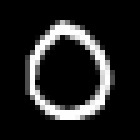

In [4]:
def print_image(idx, data, labels):
    scale= 5
    print(labels[idx])
    return Image.fromarray(np.repeat(np.repeat(data[idx,:,:], scale, axis=1), scale, axis=0))
N = train_data.shape[0]
idx = int(N*np.random.rand())
print_image(idx, train_data, train_labels)

(array([5923.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6742.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

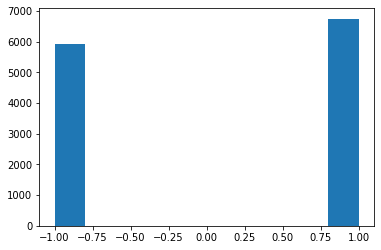

In [5]:
plt.hist(train_labels)

(array([460.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 571.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

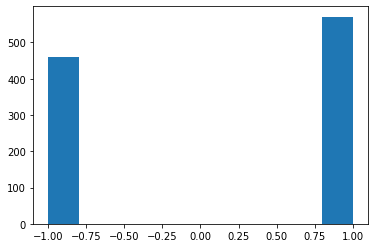

In [6]:
plt.hist(test_labels)

## Split into 10 random disjoint subsets

In [7]:
np.random.seed(0)
N_workers = 10
N_train = 600
print(N_train)
indexes_ = np.random.choice(N_train, size=N_train, replace=False, p=None)
indexes_ = list(indexes_.reshape(10, -1))
X = [np.hstack((train_data[i].reshape(int(N_train/N_workers), -1)/255,np.ones((int(N_train/N_workers),1)))) for i in indexes_]
y = [train_labels[i].reshape(-1,1) for i in indexes_]

600


In [8]:
N_test = test_data.shape[0]
X_test = np.hstack((test_data.reshape(N_test, -1)/255,np.ones((N_test,1))))
y_test = test_labels.reshape(-1, 1)

# Define connectivity
To implement the two-star graph, we use a binary connectivity matrix, just to see which nodes are directly connected:

$$  A = 
\begin{bmatrix} 
1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 \\
1 & 1 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1
\end{bmatrix}  $$

In [9]:
A = np.identity(10, dtype='int8')
A[4,0:6] = 1
A[5,4:10] = 1
A[0:5,4] = 1
A[5:10,5] = 1
print(A)
A = A.astype('bool')


[[1 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 1]]


### Compute Grad

In [10]:
def compute_gradient(w, X, Y, lambda_):
    # returns a vector of shape w.shape, with gradients of w
    N = X.shape[0]
    L = hinge_loss(w, X, Y).flatten()
    YX_neg = -Y*X # (N, d)
    YX_neg[L == 0, :] = 0
    g = np.sum(YX_neg, axis=0, keepdims=1)
    g = g.T/N
    
    reg =  2*lambda_ * w
#     set_trace()

    return g + reg

### Compute hingeloss

In [11]:
def hinge_loss(w, X, Y):
#     set_trace()
    # returns the hinge loss for each datapoint in (X,Y) as a vector (N,1)
    (N, d) = X.shape
    assert w.shape == (d,1)
    assert Y.shape == (N,1)
    L = 1. - Y * (X @ w) # (N,1)
#     set_trace()
    L[L < 0] = 0.
    return L

### Cost

In [12]:
def cost(w, X, Y):
    return np.sum(hinge_loss(w,X,Y))

### Predict

In [13]:
def predict(w, X):
    return np.sign(X @ w)

### Accuracy

In [14]:
def accuracy(w, X, Y):
    N = X.shape[0]
    preds = predict(w, X)
    corrects = np.sum(preds == Y)
    return corrects/N

### Average over neighbors

In [15]:
def average_neighbors(W, A, noise_std, p_val):
    # return an average of the weights between the neighbors
    # the return is of shape W.shape
    (d,N_neighs) = W.shape
    for i in range(N_neighs):
        Ai = A[i,:]
        degree_i = np.sum(Ai)
#         set_trace()
        w_bar = np.sum(W[:, Ai], axis=1, keepdims=1) 
        for n in range(degree_i - 1):
            w_bar += np.random.normal(loc=0, scale=noise_std)*(np.random.rand() < p_val)
        assert w_bar.shape == (d, 1)
        W[:,[i]] = w_bar/degree_i
    return W

### Compute z minus mu for a specific node

In [16]:
def compute_z_minus_mu(worker_i, Z, M, A):
    edge_idxs = np.where(A[worker_i,:] == 1)[0]
    # remove self from edge_idxs
    edge_idxs = edge_idxs[np.where(edge_idxs != worker_i)]
    
    summator = 0
    for e in edge_idxs:
        summator += (Z[:, [e], worker_i] - M[:, [e], worker_i])
    
    return summator

### Def solver

In [17]:
def solver(X, Y, X_test, Y_test, A, W, num_iters, alpha, rho, lambda_, epsilon, optimizer = "DSGM",
           mem=False, return_cost=False, verbose=True, seed=-1, p_val=0, R_val=0):
 
    N_workers = len(X)
    dw = W.shape[0]
    assert W.shape[1] == N_workers
    
    noise_std = R_val**0.5
    
    if seed != -1:
        np.random.seed(seed)
    
    cost_ = np.zeros(num_iters+1)
#     cost_index = 9
    if return_cost:
        cost_[0] = accuracy(W[:,[0]], X_test, Y_test)
    
#     set_trace()
    if (optimizer == "DSGM"): # decentralized subgradient method
        for i in range(num_iters):
            W = average_neighbors(W, A, noise_std, p_val)
            for worker_i in range(N_workers):
#                 set_trace()
                w = W[:,[worker_i]]
                g = compute_gradient(w, X[worker_i], Y[worker_i], lambda_)
                W[:,[worker_i]] = w - alpha * g
                
            if return_cost:
                c = 0
                for worker_i in range(N_workers):
                    c += accuracy(W[:,[worker_i]], X_test, Y_test)
                cost_[i+1] = c/N_workers
                
        if (verbose):
            print("DSGM: Number of iterations: ", num_iters, "/", num_iters)
    
    if (optimizer == "ADMM"):

        # set up matrix Z to contain all auxiliary edge variables
        # set up matrix M to contain all dual variables mu

        dz = dw
        Z = np.zeros(shape=(dz,N_workers,N_workers))
        M = np.zeros(shape=(dz,N_workers,N_workers))

        # compute degrees = number of neighbors excluding itself
        degs = np.sum(A,axis=1) - 1

        for i in range(num_iters):
            for worker_i in range(N_workers):
                w = W[:,[worker_i]]
                g = compute_gradient(w, X[worker_i], Y[worker_i], lambda_)

                sum_z_minus_mu = compute_z_minus_mu(worker_i, Z, M, A)
                W[:,[worker_i]] = (1/(rho*degs[worker_i])) * (rho*sum_z_minus_mu - g)

            for worker_i in range(N_workers):
                w = W[:,[worker_i]]
                # loop over neighbors
                edges = np.where(A[worker_i,:] == 1)[0]
                for e in edges:
                    if e != worker_i:
                        Z[:, [e], worker_i] = (1/2) * (w + W[:,[e]] + (1/rho)*(M[:, [e], worker_i] + M[:, [worker_i], e]))

            for worker_i in range(N_workers):
                w = W[:,[worker_i]]
                edges = np.where(A[worker_i,:] == 1)[0]
                for e in edges:
                    if e != worker_i:
                        M[:, [e], worker_i] = M[:, [e], worker_i] + rho*(w - Z[:, [e], worker_i])
            
            if return_cost:
                c = 0
                for worker_i in range(N_workers):
                    c += accuracy(W[:,[worker_i]], X_test, Y_test)
                cost_[i+1] = c/N_workers

        if (verbose):
            print("ADMM: Number of iterations: ", num_iters, "/", num_iters)
            print("ADMM: final norm: ", np.linalg.norm(g))
    
    return cost_, W

# Run SVM solver on data

## DSGM

In [18]:
d = X[0].shape[1]
np.random.seed(1)
w = np.random.rand(d,10)

rho = 0
alpha = 5 # for DGSM
num_iters = 500
lambda_ = 0
epsilon = 0
time1 = time.time()

cost_dsgm, w_out_dsgm = solver(X, y, X_test, y_test, A, w, num_iters, alpha, rho, lambda_, epsilon, optimizer = "DSGM", 
                        mem=False, return_cost=True, verbose=True, seed=-1, p_val=0, R_val=0)
time2 = time.time()
print("Runtime DSGM num_iters=", num_iters, ":", time2-time1)

DSGM: Number of iterations:  500 / 500
Runtime DSGM num_iters= 500 : 3.687000274658203


final cost DSGM 0.9970902036857419
final acc: 0.997090203685742
Number of correct: 1028 of 1031


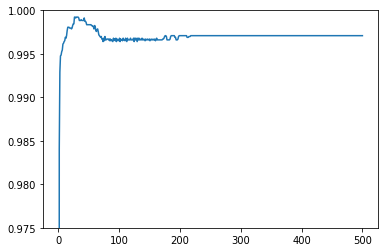

In [19]:
plt.plot(cost_dsgm)
print("final cost DSGM", cost_dsgm[-1])

# plt.yscale('log')
plt.ylim(.975,1)

N_test = X_test.shape[0]
w_dsgm = np.mean(w_out_dsgm, axis=1, keepdims=1)
acc_final = accuracy(w_dsgm, X_test, y_test)
print("final acc:", acc_final)
print("Number of correct:", int(acc_final*N_test), "of", N_test)

## ADMM

In [37]:
d = X[0].shape[1]
np.random.seed(1)
w = np.random.rand(d,10)

rho = 0.1 # for ADMM
num_iters = 500
lambda_ = 0
epsilon = 0
time1 = time.time()

cost_admm, w_out_admm = solver(X, y, X_test, y_test, A, w, num_iters, alpha, rho, lambda_, epsilon, optimizer = "ADMM", 
                        mem=False, return_cost=True, verbose=True, seed=-1, p_val=0, R_val=0)
time2 = time.time()
print("Runtime ADMM num_iters=", num_iters, ":", time2-time1)

ADMM: Number of iterations:  500 / 500
ADMM: final norm:  0.0
Runtime ADMM num_iters= 500 : 5.2099950313568115


In [38]:
plt.plot(cost_admm)
print("final cost ADMM", cost_admm[-1])
# plt.yscale('log')
plt.ylim(.975, 1)


N_test = X_test.shape[0]
w_admm = np.mean(w_out_admm, axis=1, keepdims=1)
acc_final = accuracy(w_admm, X_test, y_test)
print("final acc:", acc_final)
print("Number of correct:", acc_final*N_test, "of", N_test)

final cost ADMM 0.9951503394762364
final acc: 0.9951503394762367
Number of correct: 1026.0 of 1031


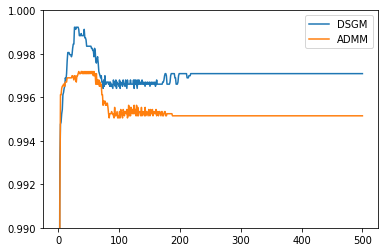

In [39]:
plt.plot(cost_dsgm, label='DSGM')
plt.plot(cost_admm, label='ADMM')

# plt.yscale('log')
plt.ylim(0.990,1)
# plt.xlim(400,500)
plt.legend()

In [23]:
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[1]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[2]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[3]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[4]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[5]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[6]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[7]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[8]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[9]])**2/np.linalg.norm(w_out_admm[:,0])**2))

2.8064664350814415e-15
1.6928015565046724e-15
6.716078877502134e-07
1.52994517175247e-08
4.2552276965910344e-07
1.2715977408107607e-07
5.416557298257949e-07
3.8185457361446355e-07
3.8179275194579133e-07


In [24]:
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[1]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[2]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[3]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[4]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[5]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[6]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[7]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[8]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[9]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))

0.0
0.0
0.0
3.654991047185849e-35
2.2122190779410073e-33
2.8066255039841115e-33
2.8066255039841115e-33
2.8066255039841115e-33
2.8066255039841115e-33
